In [148]:
import sys
sys.path.append("..")

import chromadb
import torch
from chemspace import ProjConfig, Projector
from chemspace import Encoder
from torch.utils.data import Dataset
from typing import Optional, Union
import pandas as pd

import rdkit.Chem as Chem
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles, Draw, AllChem


In [2]:
class PubChemDataset(Dataset):
    def __init__(self,
                 path: str,
                 frac: Optional[Union[float, None]] = None
                ) -> None:
        self.data = pd.read_csv(path)
        self.data = self.data[['SMILES', 'AllText']].dropna().reset_index(drop=True)
        if frac:
            self.data = self.data.sample(frac=frac).reset_index(drop=True)

    def __getitem__(self, index):
        sml = self.data["SMILES"][index]
        desc = self.data["AllText"][index]
        return {
            "sml": sml,
            "desc": desc
        }

    def __len__(self) -> int:
        return len(self.data)

In [3]:
config = ProjConfig(
    input_size=384,
    hidden_size=256,
    output_size=512,    
)
P_sml_config = config
P_sml = Projector(**vars(P_sml_config))
E_sml = Encoder()

P_desc_config = config
P_desc = Projector(**vars(P_desc_config))
E_desc = Encoder()

P_sml.load_state_dict(torch.load("P_sml.pt"))
P_desc.load_state_dict(torch.load("P_desc.pt"))

<All keys matched successfully>

In [140]:
torch.manual_seed(42)

client = chromadb.Client()
collection = client.create_collection(name="smiles", metadata={"hnsw:space": "l2"})

ds = PubChemDataset("../chemspace/Dataset/Data/Dataset.csv.gz", frac=0.01)
split = [0.9, 0.1]
print(sum(split), len(ds))
train_df, test_df = torch.utils.data.random_split(ds, split)

ids=[]
documents=[]
embeddings=[]
for id, mol in enumerate(train_df):
  ids.append(f"id{id}")
  documents.append(mol['sml'])
  embeddings.append(P_sml(E_sml(mol['sml'])).mean(dim=1).squeeze().tolist())

collection.add(
    ids=ids,
    documents=documents,
    embeddings=embeddings,
)

/var/folders/v4/1gpmxzfd7w5crqt03c05fq7c0000gn/T/ipykernel_87201/193638246.py:6: DtypeWarning: Columns (1,2,3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(path)


1.0 3223


(2S,3R,4S,5S,6R)-2-[[(2R,3S)-3,5-dihydroxy-2-(4-hydroxy-3-methoxyphenyl)-3,4-dihydro-2H-chromen-7-yl]oxy]-6-(hydroxymethyl)oxane-3,4,5-triol is a natural product found in Picea abies with data available.


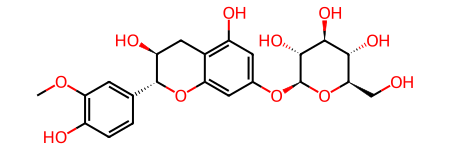

In [172]:
mol = train_df[17]
sml = mol['sml']
desc = mol['desc']

# sml = 'CC(=O)NC1C(C(C(OC1O)COS(=O)(=O)O)OC2C(C(C(C(O2)C(=O)O)OC3C(C(C(C(O3)CO)OC4C(C(C(C(O4)C(=O)O)O)O)OS(=O)(=O)O)OS(=O)(=O)O)NS(=O)(=O)O)O)OS(=O)(=O)O)O'
# desc = "Standard or unfractionated heparin is a complex mixture of naturally occurring glycosaminoglycans and is used as an anticoagulant to treat venous thrombosis or to prevent thrombosis in high risk patients. Heparin therapy is associated with frequent elevations in serum aminotransferase levels that are typically transient and not associated with clinical symptoms or significant liver injury.  Ardeparin, marketed under the US trade name Normiflo, is a low molecular weight heparin (LMWH) anticoagulant used for the prevention of postoperative venous thrombosis. Ardeparin is derived via peroxide degradation of heparin extracted from porcine intestinal mucosa. Its molecular weight ranges from 2000 to 15,000 with an average molecular weight of 5500 to 6500. Normiflo was withdrawn from the US market in March 2000. Unfractionated heparin (UH) is a heterogenous preparation of anionic, sulfated glycosaminoglycan polymers with weights ranging from 3000 to 30,000 Da. It is a naturally occurring anticoagulant released from mast cells. It binds reversibly to antithrombin III (ATIII) and greatly accelerates the rate at which ATIII inactivates coagulation enzymes thrombin (factor IIa) and factor Xa. UH is different from low molecular weight heparin (LMWH) in the following ways: the average molecular weight of LMWH is about 4.5 kDa whereas it is 15 kDa for UH; UH requires continuous infusions; activated partial prothrombin time (aPTT) monitoring is required when using UH; and UH has a higher risk of bleeding and higher risk of osteoporosis in long term use. Unfractionated heparin is more specific than LMWH for thrombin. Furthermore, the effects of UH can typically be reversed by using protamine sulfate. Enoxaparin is a common low-molecular-weight heparin (LMWH) used in the prevention and management of various thromboembolic disorders. Initially approved by the FDA in 1993, it is administered by a subcutaneous or intravenous injection and marketed by several pharmaceutical companies. Enoxaparin markedly reduces the incidence of venous thromboembolism in hospitalized patients when compared to unfractionated [heparin], without increasing the risk of serious bleeding. Dalteparin, a low molecular weight heparin (LMWH) prepared by nitrous acid degradation of unfractionated heparin of porcine intestinal mucosa origin, is an anticoagulant. It is composed of strongly acidic sulphated polysaccharide chains with an average molecular weight of 5000 and about 90% of the material within the range of 2000-9000. LMWHs have a more predictable response, a greater bioavailability, and a longer anti-Xa half life than unfractionated heparin. Dalteparin can also be safely used in most pregnant women. Low molecular weight heparins are less effective at inactivating factor IIa due to their shorter length compared to unfractionated heparin. Tinzaparin is a low molecular weight heparin (LMWH), produced by enzymatic depolymerization of unfractionated heparin from porcine intestinal mucosa. It is a heterogeneous mixture of with an average molecular weight between 5500 and 7500 daltons. Tinzaparin is composed of molecules with and without a special site for high affinity binding to antithrombin III (ATIII). This complex greatly accelerates the inhibition of factor Xa. It is an anticoagulant and considered an antithrombotic. Tinzaparin must be given either subcutaneously or parenterally. LMWHs are less effective at inactivating factor IIa due to their shorter length compared to unfractionated heparin. Nadroparin is a low molecular weight heparin (LMWH) which, when bound to antithrombin III (ATIII), accelerates the inactivation of factor II and factor Xa. Nadroparin halts the coagulation pathway by inhibiting the activation of thrombin (factor IIa) by factor Xa. The amplification of the fibrin clotting cascade is stopped once factors Xa and IIa are inactivated. It is derived from porcine sources and has a mean molecular size of 5000 daltons. Low molecular weight heparins are less effective at inactivating factor IIa due to their shorter length compared to unfractionated heparin. Bemiparin is an antithrombotic and belongs to the group of drugs known as the low molecular weight heparins (LMWH). Like semuloparin, bemiparin is classified as an ultra-LMH because of its low mean molecular mass of 3600 daltons, which is a unique property of this class.  These heparins have lower anti-thrombin activity than the traditional low molecular weight heparins and act mainly on factor-Xa, reducing the risk of bleeding due to selectivity for this specific clotting factor.  Interestingly, current research is underway for the potential benefit of bemiparin in the treatment of tumors and diabetic foot ulcers. Reviparin is a low molecular weight heparin which seems to have a better safety profile than unfractionated heparin. It is prepared from porcine intestinal mucosa by nitrous acid depolymerization. Reviparin has a molecular weight of 3.9 kDa. It was developed by Abbott laboratories and in 2009, reviparin presented an orphan drug designation by the FDA. Parnaparin is an heparin of low molecular weight with antithrombotic effects. Certoparin is part of the heparins of low molecular weight that presents high activity against the coagulation factor Xa. It is normally used to prevent deep venous thrombosis. Enoxaparin is a low molecular weight, synthetic heparin. As an anticoagulant/antithrombotic agent, enoxaprin's mechanism of action is similar to that of heparin, although it exhibits a higher ratio of anti-Factor Xa to anti-Factor IIa activity. This agent also has anti-inflammatory properties, inhibiting monocyte adhesion to tumor necrosis factor alpha- or lipopolysaccharide-activated endothelial cells.  Compared to unfractionated heparins, the use of enoxaparin is associated with lower incidences of osteoporosis and heparin-induced thrombocytopenia. (NCI04) Dalteparin is a low molecular weight, synthetic heparin. As an anticoagulant/antithrombotic agent, dalteparin binds to antithrombin and enhances the inhibition of Factor Xa. Compared to unfractionated heparins, the use of dalteparin is associated with lower incidences of osteoporosis and heparin-induced thrombocytopenia. (NCI04) Bemiparin is a second generation, synthetic, low-molecular-weight heparin (LMWH) with anticoagulant activity. Derived, after depolymerisation and fractionation, from medical-grade porcine unfractionated heparin (UFH), bemiparin has an average molecular weight of 3,600 daltons and has a higher anti-factor Xa/anti-factor IIa ratio (8:1) than first-generation LMWHs. This anticoagulant binds to antithrombin III, thereby enhancing the inactivation of activated factor X (Factor Xa) and, to a lesser extent, activated factor II (Factor IIa). Compared to unfractionated heparins, the use of bemiparin is associated with lower incidences of major bleeding, osteoporosis, and heparin-induced thrombocytopenia. Bemiparin also promotes a greater release of tissue factor pathway inhibitor than UFH or dalteparin. Heparin is a sulfur-rich glycosaminoglycan with anticoagulant property. Heparin binds to antithrombin III to form a heparin-antithrombin III complex. The complex binds to and irreversibly inactivates thrombin and other activated clotting factors, such as factors IX, X, XI, and XII, thereby preventing the polymerization of fibrinogen to fibrin and the subsequent formation of clots. Semuloparin is an ultralow-molecular-weight heparin (ULMWH) (Mw: 2000-3000 daltons)consisting of a polydisperse mixture of oligomeric heparin fragments with potential anticoagulant activity. Ultralow-molecular-weight heparin AVE5026 binds to and activates antithrombin III (ATIII), which may result in the inhibition of activated factor Xa and, to a much lesser extent, factor IIa (thrombin) and so the inhibition of fibrin formation. Compared to low-molecular-weight heparins (LMWHs), AVE5026 exhibits an even higher ratio of anti-Factor Xa to anti-Factor IIa activity (>30:1). Compared to unfractionated heparins, the use of LMWHs is associated with lower incidences of major bleeding, osteoporosis and heparin-induced thrombocytopenia. Like LMWHs, this agent may inhibit tumor growth by regulating angiogenesis and apoptosis. AVE5026 is prepared by partial depolymerization of unfractionated porcine mucosal heparin. Tinzaparin is a low molecular weight heparin (LMWH), obtained by controlled enzymatic depolymerization of heparin from porcine intestinal mucosa, with antithrombotic properties. Tinzaparin is a potent inhibitor of several activated coagulation factors, especially Factors Xa and IIa (thrombin); its primary activity is mediated through the plasma protease inhibitor antithrombin. In addition, this agent may inhibit angiogenesis through: 1) competitive binding of the heparin-binding sites on endothelial cells for the proangiogenic cytokines vascular endothelial growth factor (VEGF) and beta-fibroblast growth factor (beta-FGF) and 2) increasing the release of tissue factor pathway inhibitor (TFPI), a negative regulator of angiogenesis. Low Molecular Weight Heparin is substances comprised of fragmented heparin molecules derived from unfractionated heparin that bind to antithrombin III with a molecular weight ranging from 1000 to 10,000 daltons, which causes changes in property from unfractionated heparin, including decreased protein binding, enhanced bioavailability, decreased platelet interaction, and decreased binding to thrombin. Enoxaparin is a natural product found in Sargassum myriocystum, Sargassum polycystum, and other organisms with data available."
query = P_desc(E_desc(desc))

print(desc)
ref_mol = MolFromSmiles(sml)
Chem.rdCoordGen.AddCoords(ref_mol)
ref_mol


ids [['id1545', 'id2571', 'id2401', 'id1004', 'id1339', 'id2678', 'id1079', 'id2387', 'id1542', 'id2853']]
embeddings None
documents [['COC(=O)C1=CO[C@H]([C@H]2[C@@H]1C=C[C@]2(C=O)O)O[C@H]3[C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O', 'CCCC(=O)C1=C2C(=C3C(=C1O)C=C[C@@](O3)(C)CCC=C(C)C)C(=CC(=O)O2)[C@H](CC)O', 'C[C@@H]1[C@H]([C@H]([C@@]2([C@@H]([C@]13C[C@H](OC3=O)C4=COC=C4)CCC=C2CO)CO)O)O', 'CC1=C2COC(=O)C2=C(C(=C1OC)C)O[C@H]3[C@@H]([C@H]([C@@H]([C@H](O3)CO)OC)O)O', 'C[C@@H]1CC[C@]2([C@@H]1[C@H](OC=C2C=O)O[C@H]3[C@@H]([C@H]([C@@H]([C@H](O3)CO)O)O)O)O', 'CC=CCCC(=O)C1=C(C(=C(C2(C1C(C(=O)O2)(C)NC(=O)C=CC(=O)O)C)O)C)O', 'C[C@@H]1C[C@@H]2[C@H](O2)C=CC=CC(=O)CC3=C(C(=CC(=C3)O)O)C(=O)O1', 'CC[C@@H](C1=CC(=O)OC2=C(C(=C3CC(OC3=C12)C(C)(C)O)O)C(=O)C(C)CC)O', 'C[C@H](CC[C@H]1C(=CC(=O)CC1(C)C)CO)O[C@H]2[C@@H]([C@H]([C@H]([C@H](O2)CO)O)O)O', 'C/C(=C\\C(=O)O)/CC/C=C(\\C)/CO[C@H]1[C@@H]([C@H]([C@@H]([C@H](O1)CO)O)O)O']]
metadatas [[None, None, None, None, None, None, None, None, None, None]]
distances [[0.

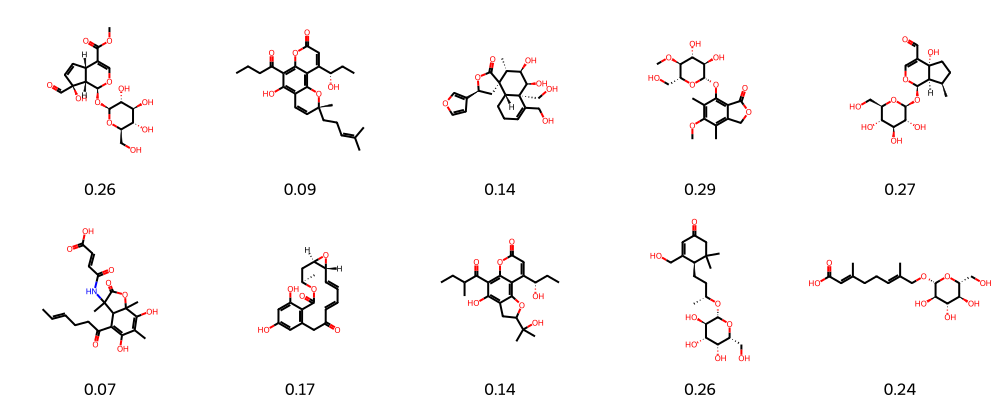

In [173]:
vecs = collection.query(
    query_embeddings=query.mean(dim=1).squeeze().tolist(),
    n_results=10
)

for k in vecs:
    print(k, vecs[k])

mols = [MolFromSmiles(doc) for doc in vecs['documents'][0]]
for m in mols:
    Chem.rdCoordGen.AddCoords(m)
sims = [
    DataStructs.TanimotoSimilarity(
            AllChem.GetMorganFingerprintAsBitVect(ref_mol, 2, nBits=2048),
            AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        ) for mol in mols
]
Draw.MolsToGridImage(mols, molsPerRow=5, legends=[f"{sim:.2f}" for sim in sims])